<a href="https://colab.research.google.com/github/msvt37/python-homework/blob/main/Whale_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 #  A Whale off the Port(folio)
 ---

 In this assignment, you'll get to use what you've learned this week to evaluate the performance among various algorithmic, hedge, and mutual fund portfolios and compare them against the S&P 500 Index.

In [1]:
# Code was written and run from Google Colaboratory using Google Drive as data disk
# Initial imports and install of Yahoo Finance (needed for Colaboratory)
import pandas as pd
import numpy as np
import datetime as dt
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
!pip install yfinance
%matplotlib inline
import yfinance as yf

# Data Cleaning

In this section, you will need to read the CSV files into DataFrames and perform any necessary data cleaning steps. After cleaning, combine all DataFrames into a single DataFrame.

Files:

* `whale_returns.csv`: Contains returns of some famous "whale" investors' portfolios.

* `algo_returns.csv`: Contains returns from the in-house trading algorithms from Harold's company.

* `sp500_history.csv`: Contains historical closing prices of the S&P 500 Index.

## Whale Returns

Read the Whale Portfolio daily returns and clean the data

In [2]:
# Reading whale returns
whales = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/HW3and4/whale_returns.csv',parse_dates=True, index_col='Date', infer_datetime_format=True)


In [3]:
# Count nulls
whales.isnull().sum()

SOROS FUND MANAGEMENT LLC      1
PAULSON & CO.INC.              1
TIGER GLOBAL MANAGEMENT LLC    1
BERKSHIRE HATHAWAY INC         1
dtype: int64

In [4]:
# Drop nulls
whales.dropna(axis=0, how='any', inplace=True)

## Algorithmic Daily Returns

Read the algorithmic daily returns and clean the data

In [5]:
# Reading algorithmic returns
algo = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/HW3and4/algo_returns.csv',parse_dates=True, index_col='Date', infer_datetime_format=True)

In [6]:
# Count nulls
algo.isnull().sum()

Algo 1    0
Algo 2    6
dtype: int64

In [7]:
# Drop nulls
algo.dropna(axis=0, how='any', inplace=True)

## S&P 500 Returns

Read the S&P 500 historic closing prices and create a new daily returns DataFrame from the data. 

In [8]:
# Reading S&P 500 Closing Prices
sandp = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/HW3and4/sp500_history.csv',parse_dates=True, index_col='Date', infer_datetime_format=True)

In [9]:
# Check Data Types  (drop $)
sandp.dtypes
sandp.Close= sandp.Close.str.replace('$', '')

In [10]:
# Fix Data Types
sandp.Close=sandp.Close.astype(float, errors='raise')

In [11]:
# Calculate Daily Returns
sp_dailyreturns= sandp.pct_change()

In [12]:
# Drop nulls
sp_dailyreturns.dropna(inplace=True)

In [13]:
# Rename `Close` Column to be specific to this portfolio.
# Done in next step

## Combine Whale, Algorithmic, and S&P 500 Returns

In [14]:
# Join Whale Returns, Algorithmic Returns, and the S&P 500 Returns into a single DataFrame with columns for each portfolio's returns.
final= pd.concat([whales, algo, sp_dailyreturns], axis=1, join='inner').dropna()
final.rename(columns={'Close':'S&P Return'}, inplace=True)

---

# Conduct Quantitative Analysis

In this section, you will calculate and visualize performance and risk metrics for the portfolios.

## Performance Anlysis

#### Calculate and Plot the daily returns.

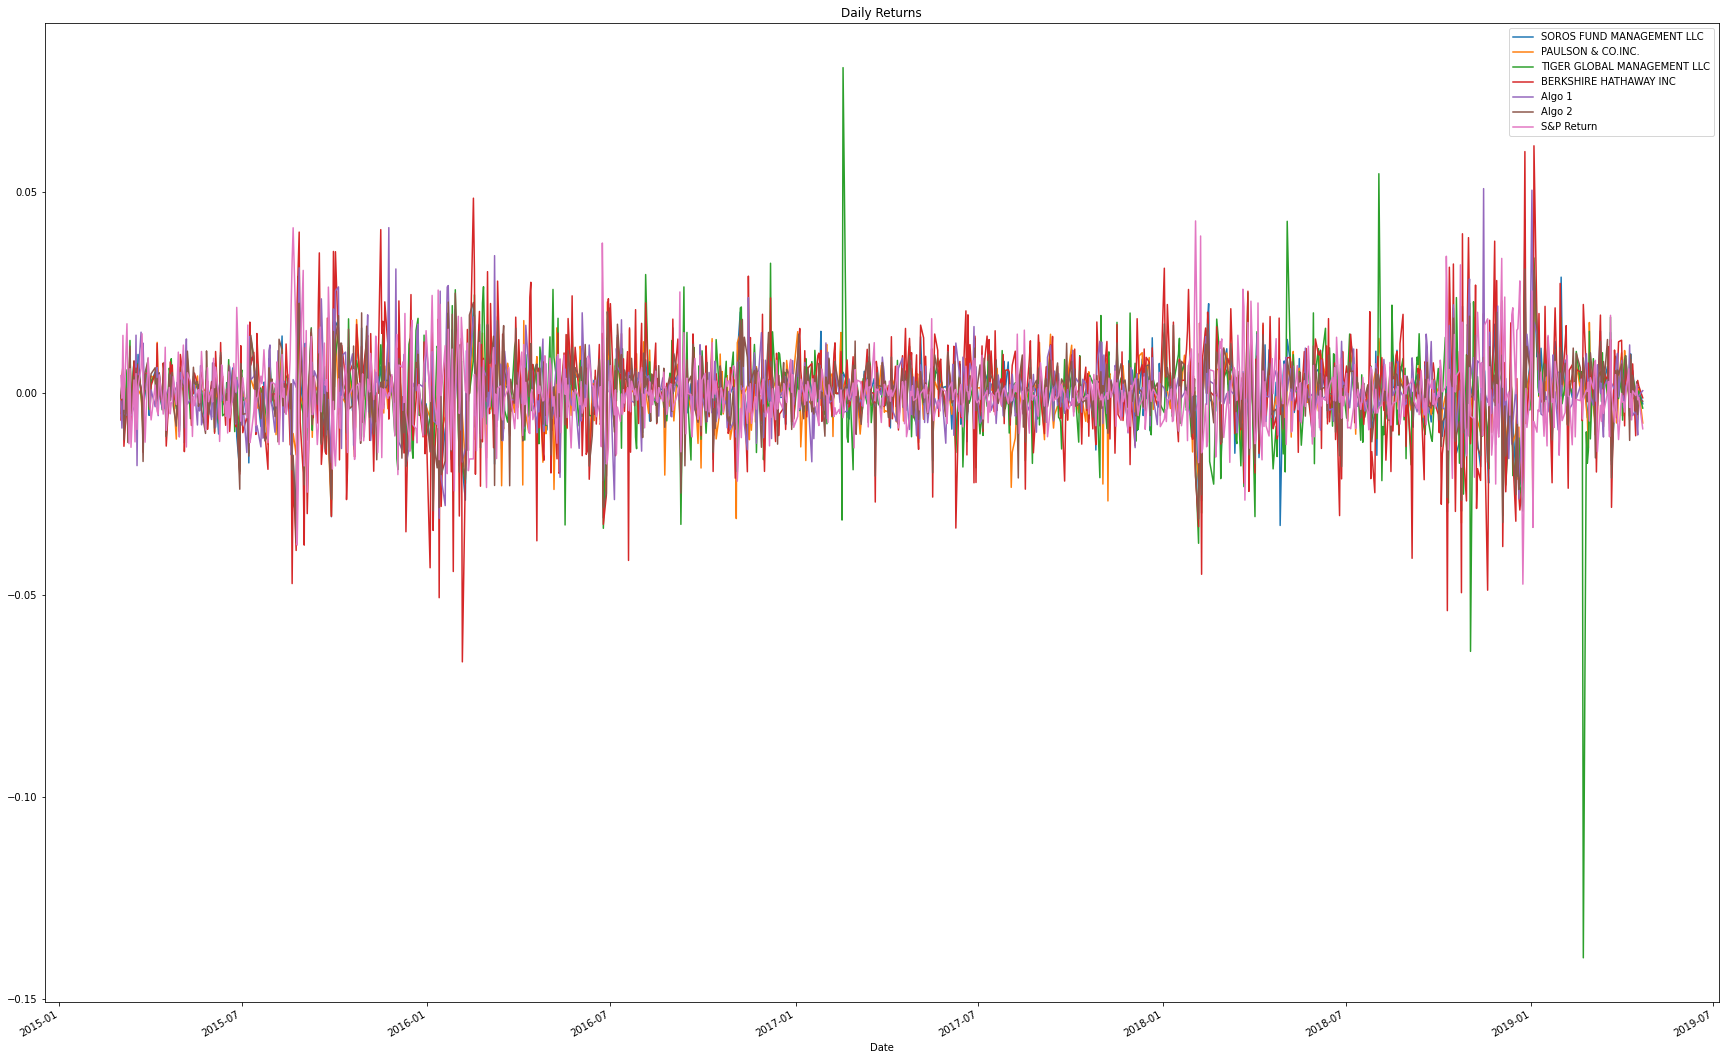

In [15]:
# Plot daily returns of all portfolios
final.plot(figsize = (30, 20), title = "Daily Returns")


#### Calculate and Plot cumulative returns.

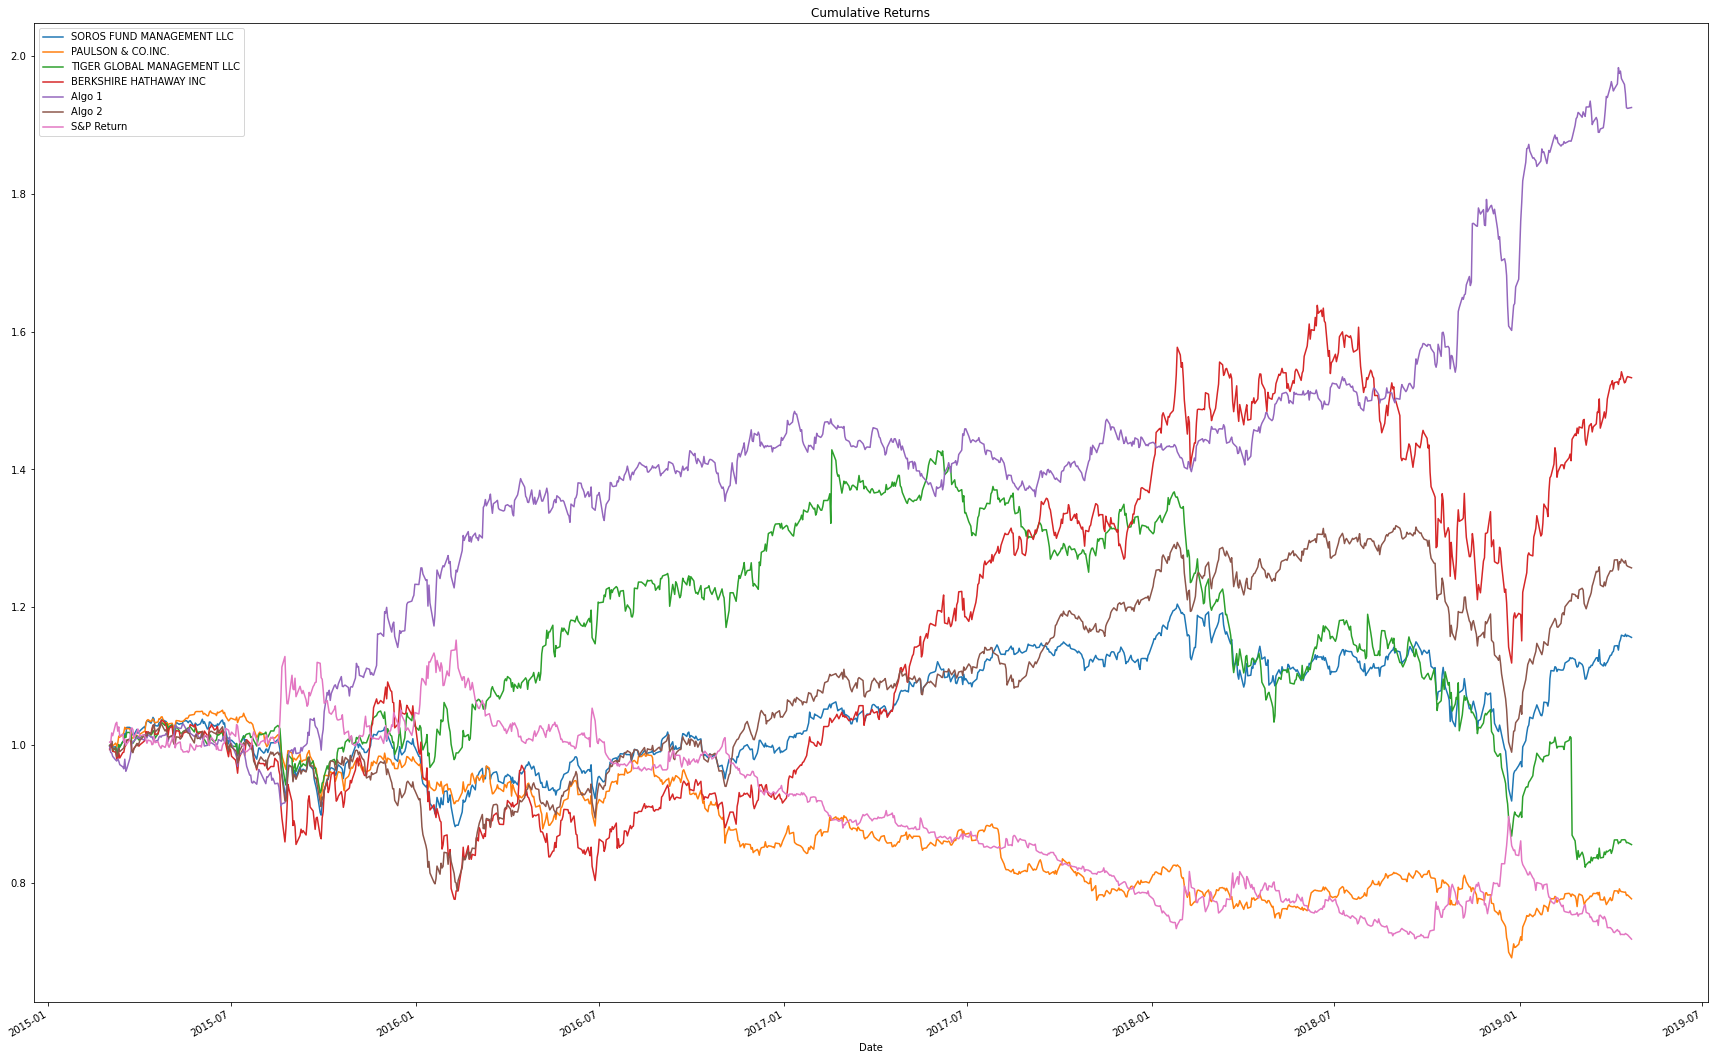

In [16]:
# Calculate cumulative returns of all portfolios
cumulative_returns = (1 + final).cumprod()
# Plot cumulative returns
cumulative_returns.plot(figsize =(30,20), title= "Cumulative Returns")   

---

## Risk Analysis

Determine the _risk_ of each portfolio:

1. Create a box plot for each portfolio. 
2. Calculate the standard deviation for all portfolios
4. Determine which portfolios are riskier than the S&P 500
5. Calculate the Annualized Standard Deviation

### Create a box plot for each portfolio


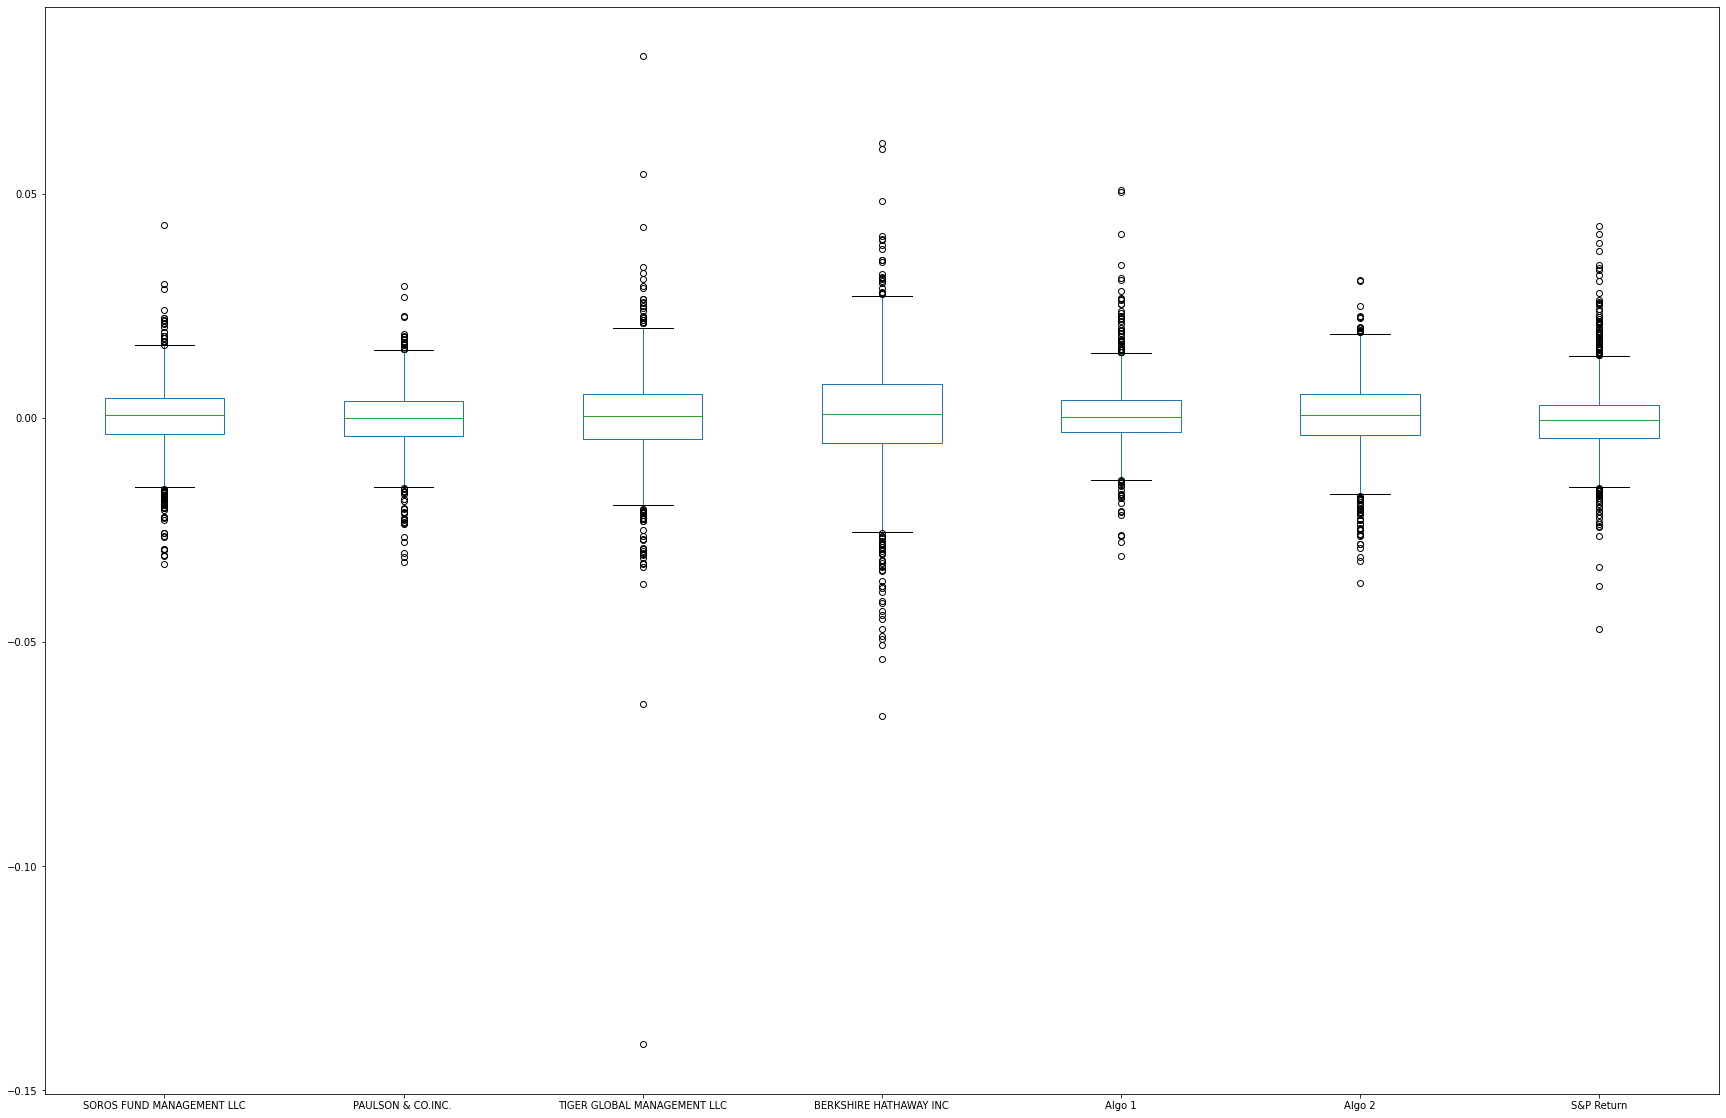

In [17]:
# Box plot to visually show risk
final.plot( kind='box', figsize = (30,20))

### Calculate Standard Deviations

In [18]:
# Calculate the daily standard deviations of all portfolios
daily_std = final.std().sort_values(ascending=False)

### Determine which portfolios are riskier than the S&P 500

In [19]:
# Calculate  the daily standard deviation of S&P 500
sandp_daily_std = final['S&P Return'].std()
# Determine which portfolios are riskier than the S&P 500 - Berkshire and Tiger Global
daily_std.where(daily_std>sandp_daily_std).dropna()

BERKSHIRE HATHAWAY INC         0.012919
TIGER GLOBAL MANAGEMENT LLC    0.010897
dtype: float64

### Calculate the Annualized Standard Deviation

In [20]:
# Calculate the annualized standard deviation (252 trading days)
annualized_std = daily_std * np.sqrt(252)

---

## Rolling Statistics

Risk changes over time. Analyze the rolling statistics for Risk and Beta. 

1. Calculate and plot the rolling standard deviation for the S&P 500 using a 21-day window
2. Calculate the correlation between each stock to determine which portfolios may mimick the S&P 500
3. Choose one portfolio, then calculate and plot the 60-day rolling beta between it and the S&P 500

### Calculate and plot rolling `std` for all portfolios with 21-day window

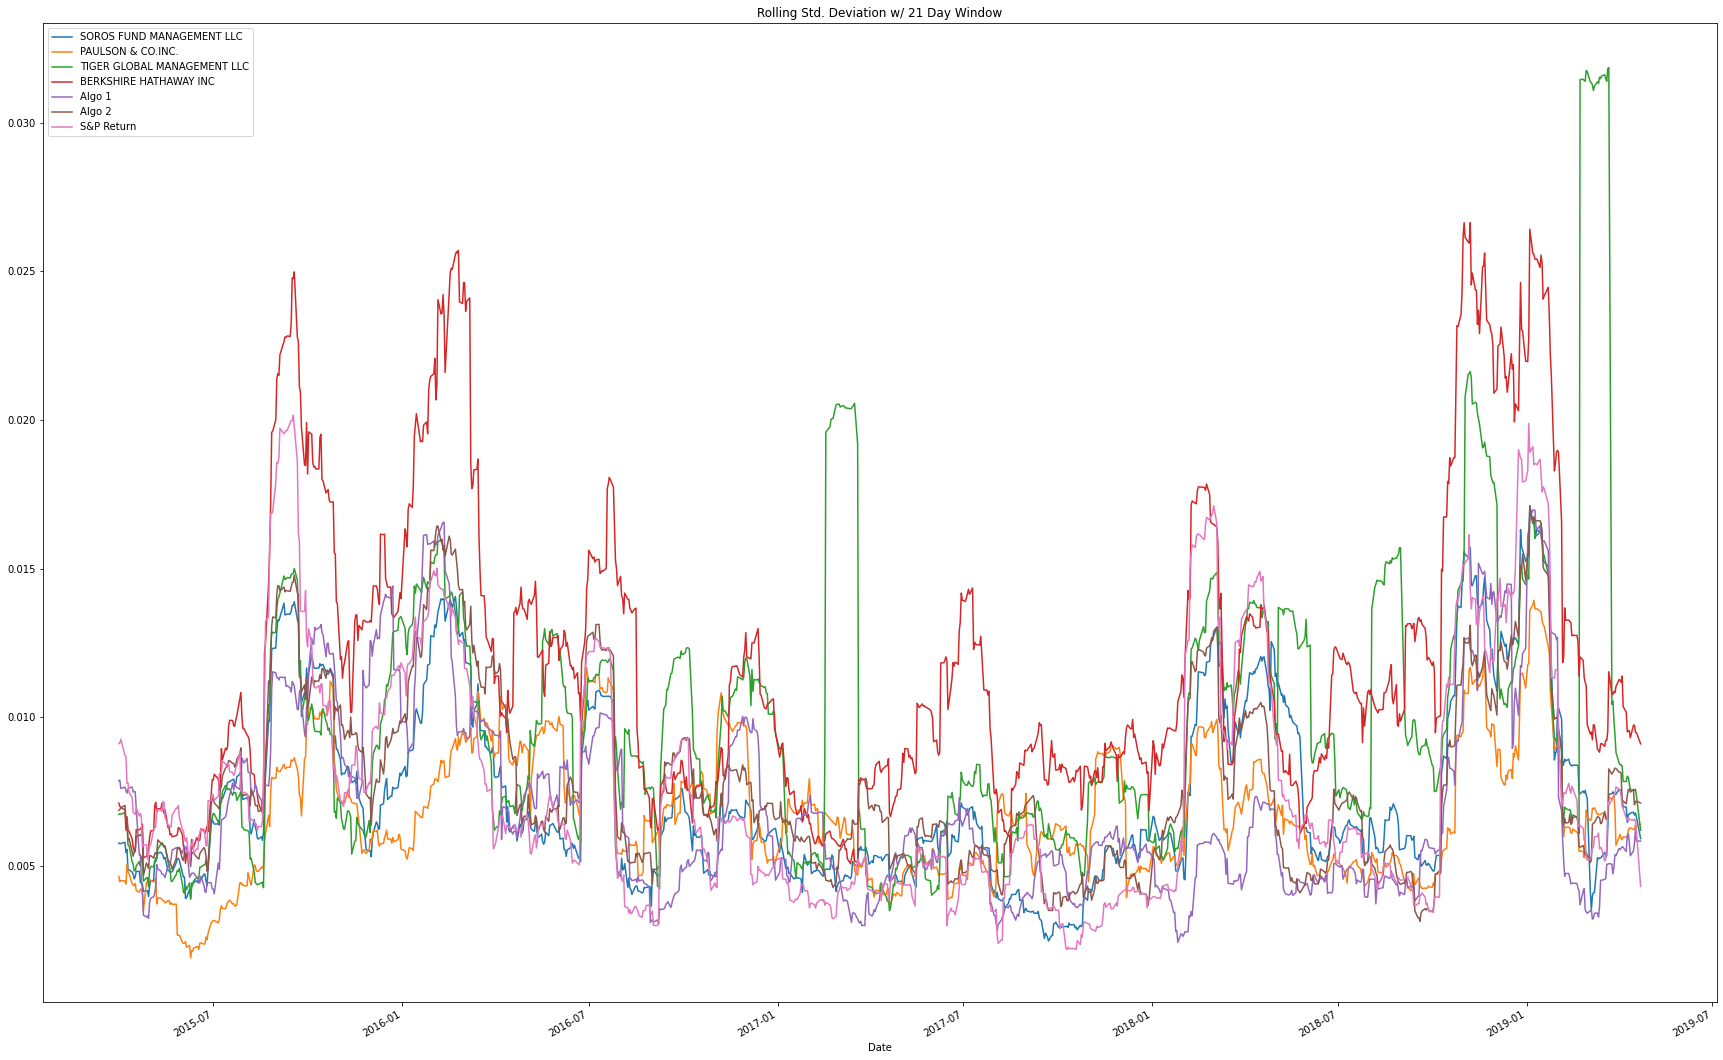

In [21]:
# Calculate the rolling standard deviation for all portfolios using a 21-day window
rolling_daily = final.rolling(21).std()

# Plot the rolling standard deviation
rolling_daily.dropna().plot(figsize = (30,20), title= "Rolling Std. Deviation w/ 21 Day Window")

### Calculate and plot the correlation

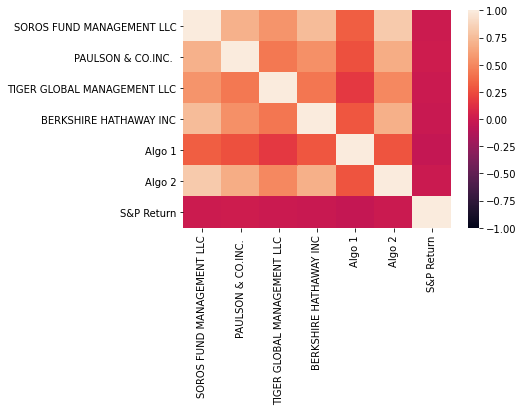

In [22]:
# Calculate the correlation
correlation = final.corr(method='pearson')
# Display de correlation matrix
sns.heatmap(correlation, vmin=-1, vmax=1)
# Lighter squares in heatmap show a correlation between portfolios, e.g. Soros Fund and Algo 2

### Calculate and Plot Beta for a chosen portfolio and the S&P 500

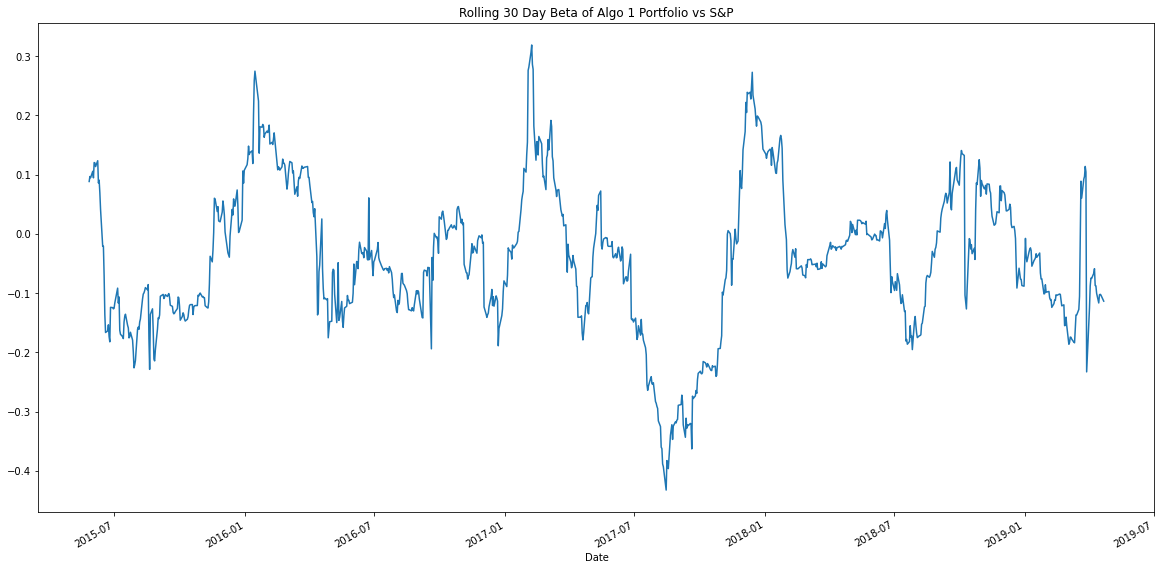

In [23]:
# Calculate covariance of a single portfolio
covariance = final['Algo 1'].cov(final['S&P Return'])
# Calculate variance of S&P 500
variance = final['S&P Return'].var()
# Computing beta
algo_beta = covariance / variance
# Plot beta trend - need 30 day rolling covariance , and variance for S&P
rolling_covariance = final['Algo 1'].rolling(window=60).cov(final['S&P Return'])
rolling_variance = final['S&P Return'].rolling(window=60).var()
rolling_beta= rolling_covariance / rolling_variance
rolling_beta.plot(figsize=(20, 10), title= 'Rolling 30 Day Beta of Algo 1 Portfolio vs S&P')


## Rolling Statistics Challenge: Exponentially Weighted Average 

An alternative way to calculate a rolling window is to take the exponentially weighted moving average. This is like a moving window average, but it assigns greater importance to more recent observations. Try calculating the [`ewm`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html) with a 21-day half-life.

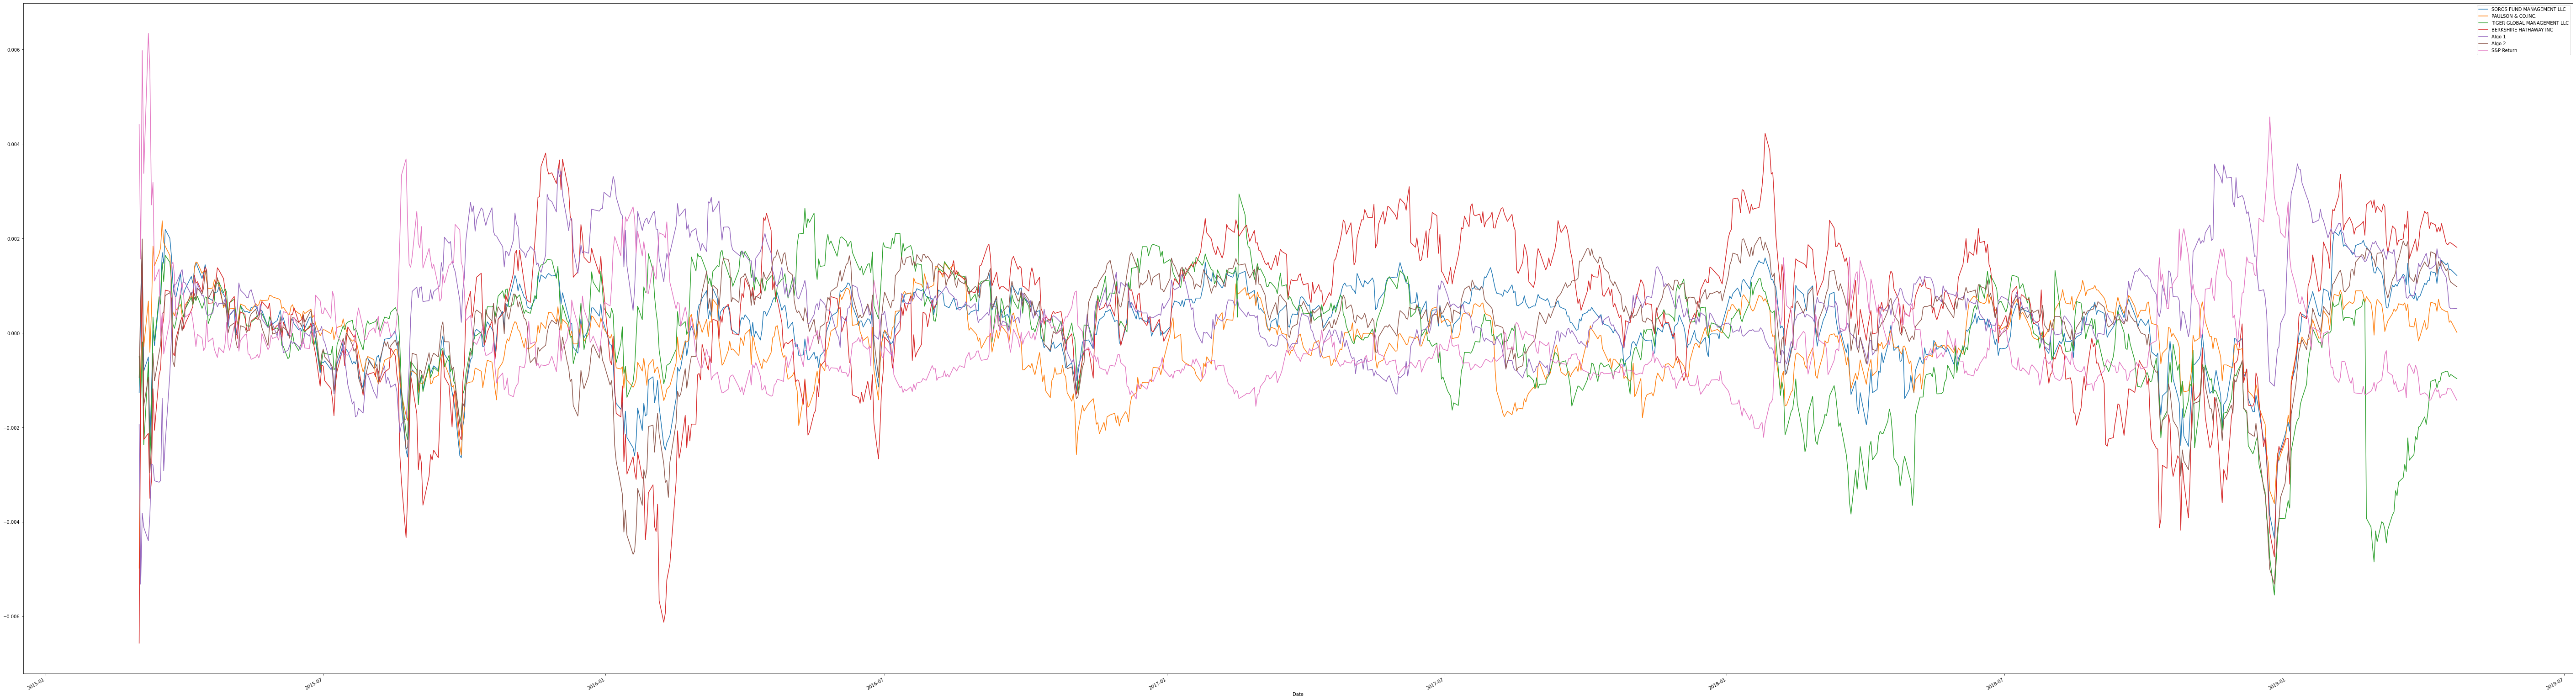

In [24]:
# Use `ewm` to calculate the rolling window
ewm_rolling = final.ewm(halflife= 21).mean()
ewm_rolling.plot(figsize = (100, 30))

---

# Sharpe Ratios
In reality, investment managers and thier institutional investors look at the ratio of return-to-risk, and not just returns alone. After all, if you could invest in one of two portfolios, and each offered the same 10% return, yet one offered lower risk, you'd take that one, right?

### Using the daily returns, calculate and visualize the Sharpe ratios using a bar plot

In [25]:
# Annualized Sharpe Ratios
sharpe_ratios = ((final.mean() * 252) / (final.std() * np.sqrt(252)))

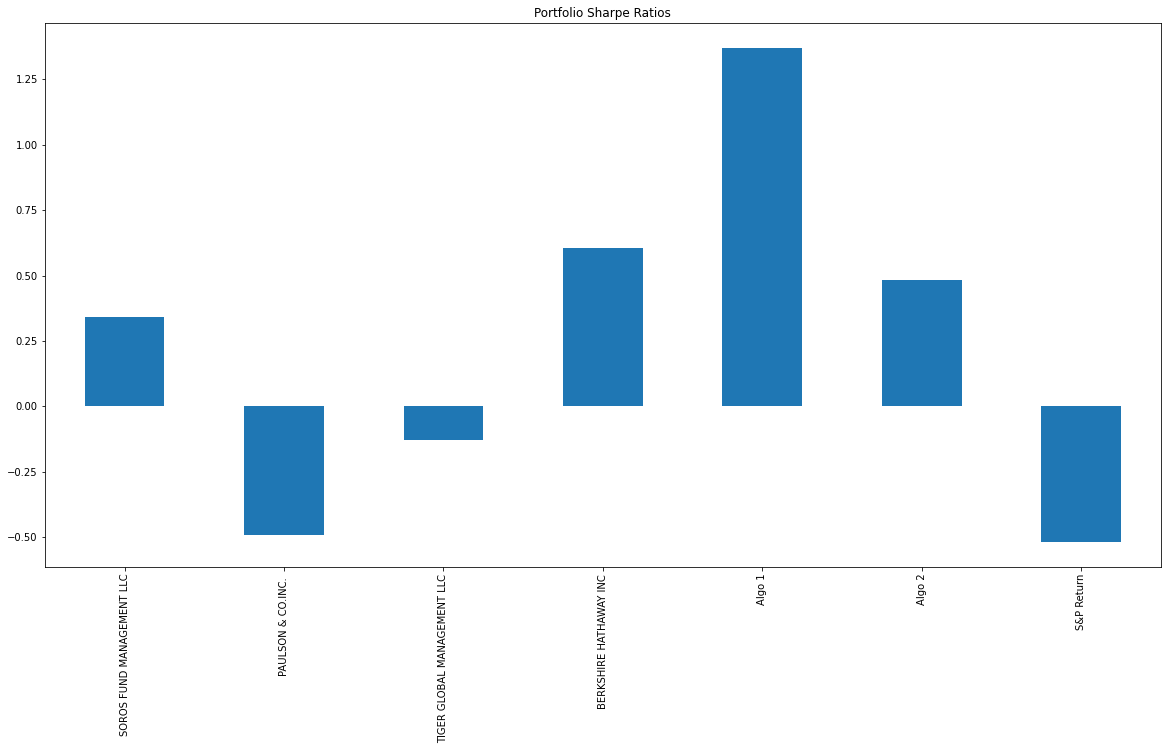

In [26]:
# Visualize the sharpe ratios as a bar plot
sharpe_ratios.plot(kind='bar', figsize= (20,10), title = "Portfolio Sharpe Ratios")

### Determine whether the algorithmic strategies outperform both the market (S&P 500) and the whales portfolios.

Since 2017, all portfolios except Paulson, have outperformed the S&P 500. Based on the Sharpe ratios calculated and performance data, the Algorithmic 1 portfolio, is clearly the leader. Algorithmic 2 lead others, only to be outperformed by Berkshirehathaway and Algorithmic 1.



---

# Create Custom Portfolio

In this section, you will build your own portfolio of stocks, calculate the returns, and compare the results to the Whale Portfolios and the S&P 500. 

1. Choose 3-5 custom stocks with at last 1 year's worth of historic prices and create a DataFrame of the closing prices and dates for each stock.
2. Calculate the weighted returns for the portfolio assuming an equal number of shares for each stock
3. Join your portfolio returns to the DataFrame that contains all of the portfolio returns
4. Re-run the performance and risk analysis with your portfolio to see how it compares to the others
5. Include correlation analysis to determine which stocks (if any) are correlated

## Choose 3-5 custom stocks with at last 1 year's worth of historic prices and create a DataFrame of the closing prices and dates for each stock.

For this demo solution, we fetch data from three companies listes in the S&P 500 index.

* `GOOG` - [Google, LLC](https://en.wikipedia.org/wiki/Google)

* `AAPL` - [Apple Inc.](https://en.wikipedia.org/wiki/Apple_Inc.)

* `COST` - [Costco Wholesale Corporation](https://en.wikipedia.org/wiki/Costco)

[*********************100%***********************]  5 of 5 completed


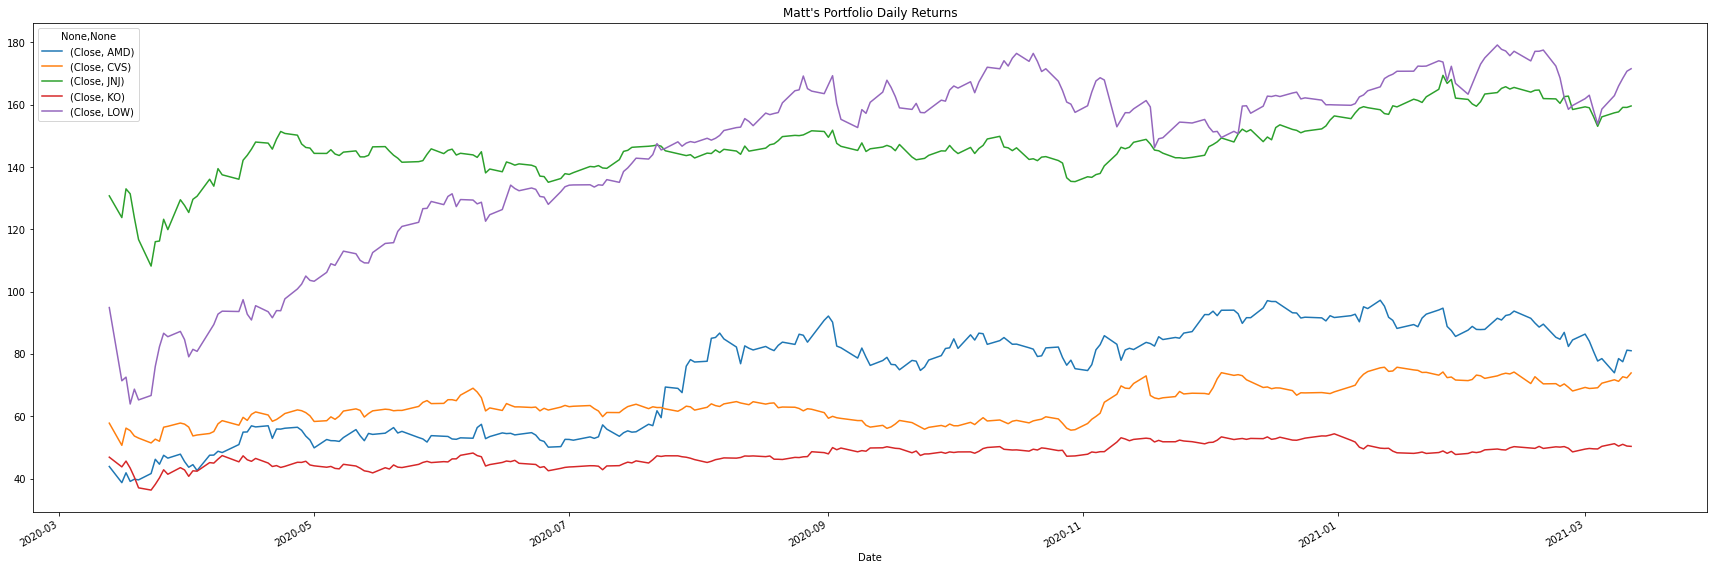

In [27]:
# Grab data from Yahoo Finance.  Using this instead of .csv files

my_portfolio = yf.Tickers("JNJ, LOW, AMD, KO, CVS")
my_portfolio_df = my_portfolio.history(period="1y")

my_portfolio_df.drop(['Dividends', 'High', 'Low', 'Open', 'Stock Splits', 'Volume'], axis=1, inplace=True)


my_portfolio_df.plot(figsize = (30, 10), title = "Matt's Portfolio Daily Returns")


In [ ]:
# Calculate daily returns
my_portfolio_df = my_portfolio_df.pct_change()
# Drop NAs
my_portfolio_df.dropna(inplace=True)
# Display sample data
my_portfolio_df

## Calculate the weighted returns for the portfolio assuming an equal number of shares for each stock

In [ ]:
# Set weights
w = [.2,.2,.2,.2,.2]

# Calculate portfolio return

weighted_returns = (w * my_portfolio_df)
portfolio_returns = weighted_returns.sum(axis=1,)
# Display sample data
portfolio_returns.head()

## Join your portfolio returns to the DataFrame that contains all of the portfolio returns

In [30]:
# Join your returns DataFrame to the original returns DataFrame
my_portfolio_df['Port Rtrns'] = portfolio_returns

In [31]:
# Only compare dates where return data exists for all the stocks (drop NaNs)


## Re-run the risk analysis with your portfolio to see how it compares to the others

### Calculate the Annualized Standard Deviation

In [32]:
# Calculate the annualized `std`
my_pf_daily_std = my_portfolio_df.std()
my_pf_annual_std = my_pf_daily_std * np.sqrt(252)

### Calculate and plot rolling `std` with 21-day window

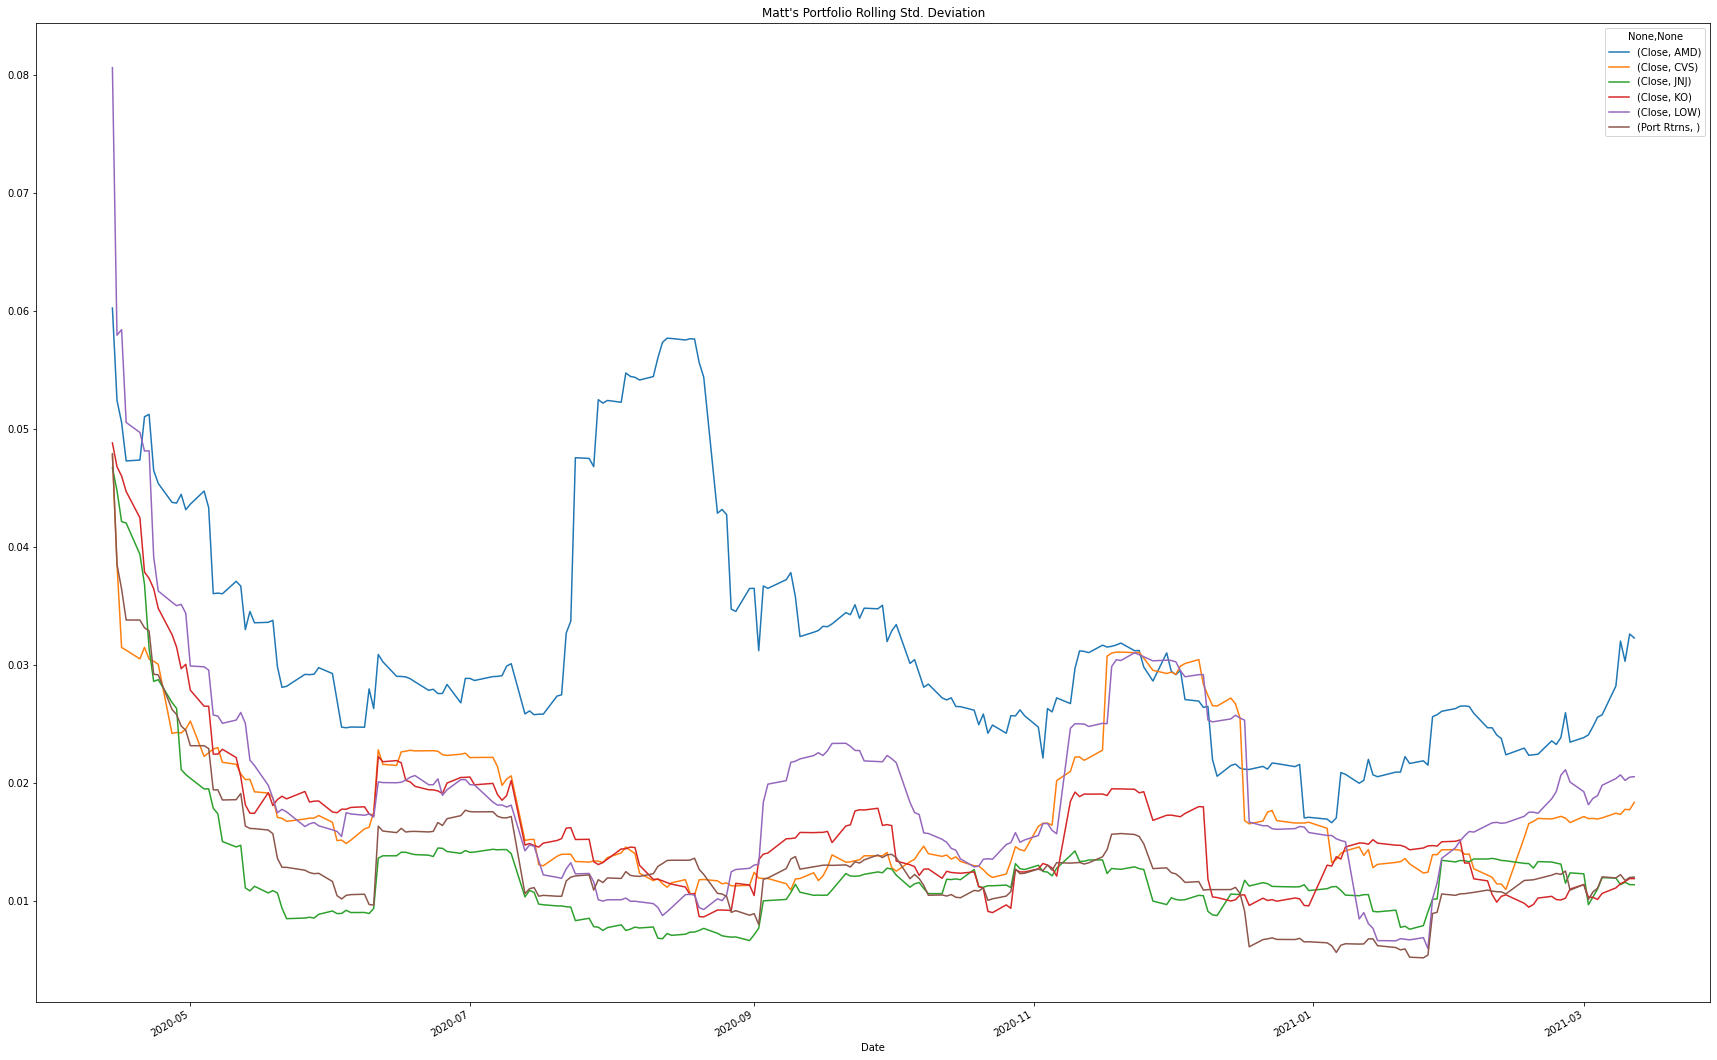

In [33]:
# Calculate rolling standard deviation
my_pf_rolling_daily = my_portfolio_df.rolling(21).std()
# Plot rolling standard deviation
my_pf_rolling_daily.dropna().plot(figsize = (30,20), title= "Matt's Portfolio Rolling Std. Deviation")

### Calculate and plot the correlation

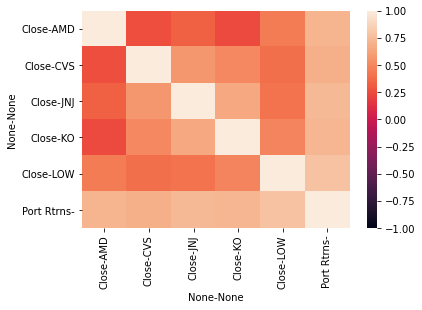

In [34]:
# Calculate and plot the correlation
my_pf_correlation = my_portfolio_df.corr(method='pearson')
sns.heatmap(my_pf_correlation, vmin=-1, vmax=1)

### Calculate and Plot Rolling 60-day Beta for Your Portfolio compared to the S&P 500

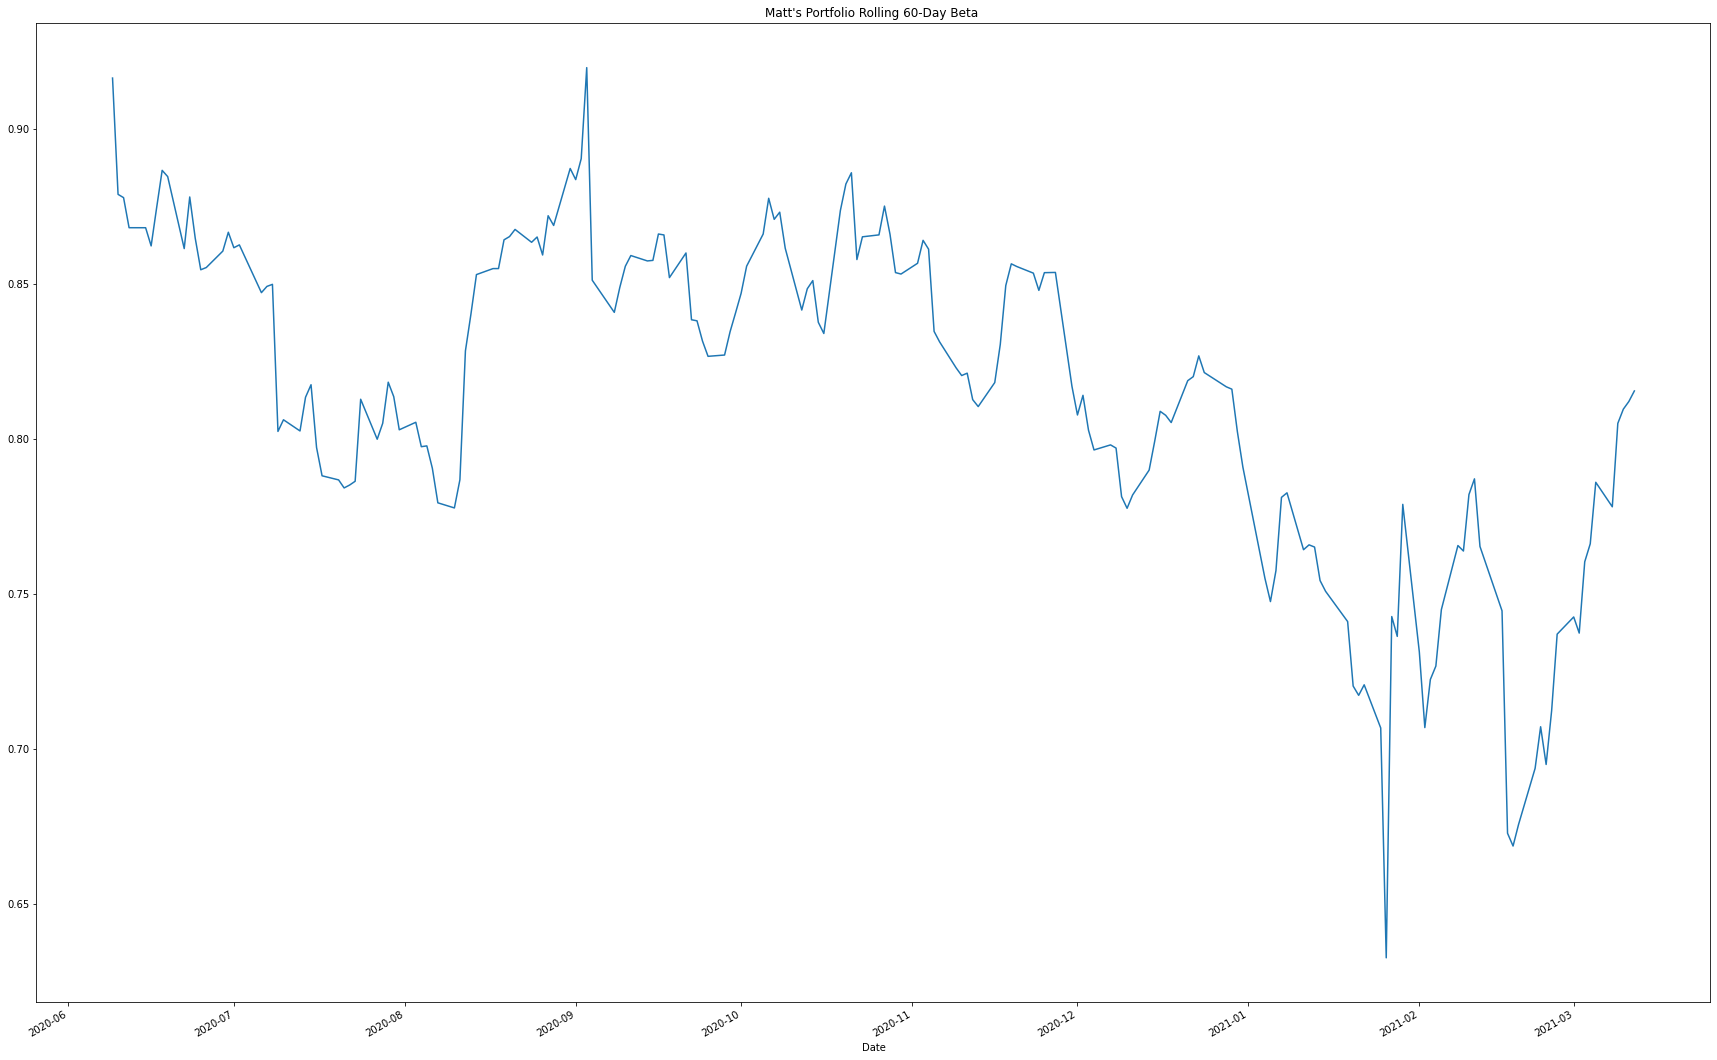

In [35]:
# Calculate and plot Beta
sandp_500 = yf.Ticker("^GSPC")
sandp_df = sandp_500.history(period="10y")
sandp_df.drop(['Dividends', 'High', 'Low', 'Open', 'Stock Splits', 'Volume'], axis=1, inplace=True)
sandp_df.rename(columns={'Close':'S&P Return'}, inplace=True)
sandp_df = sandp_df.pct_change()    

my_pf_covariance = my_portfolio_df['Port Rtrns'].cov(sandp_df['S&P Return'])
my_pf_variance = sandp_df['S&P Return'].var()
my_pf_beta = my_pf_covariance / my_pf_variance
my_pf_rolling_cov = my_portfolio_df['Port Rtrns'].rolling(window=60).cov(sandp_df['S&P Return'])
my_pf_rolling_var = sandp_df['S&P Return'].rolling(window=60).var()
my_pf_rolling_beta = my_pf_rolling_cov / my_pf_rolling_var
my_pf_rolling_beta.plot(figsize = (30,20), title = "Matt's Portfolio Rolling 60-Day Beta ")

### Using the daily returns, calculate and visualize the Sharpe ratios using a bar plot

In [36]:
# Calculate Annualzied Sharpe Ratios
my_pf_sharpe_ratios = ((my_portfolio_df.mean() * 252) / (my_portfolio_df.std() * np.sqrt(252)))

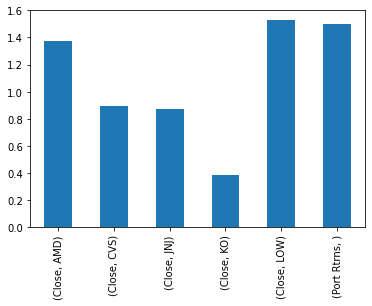

In [37]:
# Visualize the sharpe ratios as a bar plot
my_pf_sharpe_ratios.plot(kind='bar')

### How does your portfolio do?

My portfolio consists mainly of large cap value stocks (reasonable PE).  Although these stocks do not show the same level of returns as say a Tesla, or Facebook, they do show consistent postive returns with lower risk.